# The CRRA family utility functions

The constant relative risk-aversion family of utility functions are the family explored in Haghani & White's book. They have the property that it implies the same level of risk aversion to percentage changes of wealth, regardless of your absolute level of wealth.

E.g. if you have a CRRA utility and losing 10% of your wealth is equivalent to making 15%, given a starting wealth of $1M, then that ratio will be equivalent in utility terms at every other wealth level too.

CRRA utility is written as

$$U(W) = \frac{1-W^{1-\gamma}}{\gamma - 1}$$

where $\gamma$ is your risk aversion parameter (a typical value is $\gamma=2$), and $W$ is your wealth.

In [1]:
import numpy as np
import polars as pl
import seaborn as sb
import matplotlib.pyplot as plt 
from tqdm import tqdm

In [2]:
plt.style.use("../matplotlibrc")

In [3]:
def crra_utility(w: np.ndarray | float, *, gamma: float):
    '''
    Interestingly, also known as the Box-Cox transformation in stats
    https://en.wikipedia.org/wiki/Isoelastic_utility
    '''
    if gamma == 1:
        return np.log(w)
    return (1 - w**(1-gamma)) / (gamma - 1)

In [4]:
w = np.linspace(0.5, 1.5, 100)
gamma_to_name = {
    0: "$\gamma = 0$, Risk neutral (expected returns)",
    1: "$\gamma = 1$, Kelly bettor",
    2: "$\gamma = 2$, Base-case investor",
    3: "$\gamma = 3$, Risk-averse investor"
}

In [5]:
wealth_vs_utility = []

for gamma, name in gamma_to_name.items():
    utility = crra_utility(w, gamma=gamma)
    df = pl.DataFrame({"wealth": w})
    df = df.with_columns(
        pl.Series(name="utility", values=utility),
        pl.lit(gamma_to_name[gamma], dtype=pl.Utf8()).alias("gamma")
    )

    wealth_vs_utility.append(df)
wealth_vs_utility = pl.concat(wealth_vs_utility)

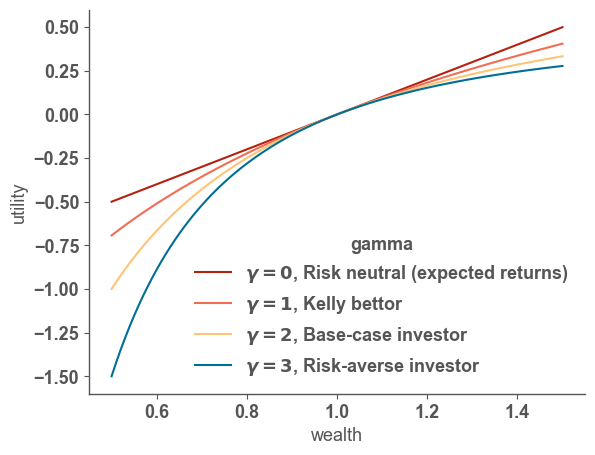

In [6]:
sb.lineplot(wealth_vs_utility, x="wealth", y="utility", hue="gamma", markers=True);

When $\gamma=0$, you are an expected-returns maximizer, you have no cost to risk, and your utility is a linear function of wealth.

Worth saying that other equivalent forms of this utility function exist. The key condition is that 

$$\text{const} = -\frac{WU''(W)}{U'(W)}$$

## A coin flipping example

Imagine you have $1M, and access to a 60/40 coin. You are able to "invest" in 25 flips of that coin. How much of your wealth should you bet on each coin flip? 

Let's simulate it first, and then see if we can arrive at the right answer analytically later.

In [7]:
import random

random.seed(42)

In [8]:
def return_on_coin_flip(w: float, *, bias: float) -> float:
    return 2.*w if random.random() < bias else 0.    

def betting_game_returns(*, initial_wealth: float, n_flips: int, bias: float, frac_to_bet_per_flip: float) -> float:
    """Assume constant fractional betting""" 
    end_wealth = initial_wealth
    for _ in range(n_flips):
        amount_to_bet = frac_to_bet_per_flip * end_wealth
        end_wealth -= amount_to_bet
        end_wealth += return_on_coin_flip(amount_to_bet, bias=bias)
    return end_wealth

In [9]:
from collections.abc import Callable

def expected_results(game: Callable, initial_wealth: float, gamma: float, n_games: int = 10_000, *args, **kwargs) -> tuple[float, float]:
    expected_returns = 0
    expected_utility = 0
    for _ in range(n_games):
        end_wealth = game(initial_wealth=initial_wealth, *args, **kwargs)
        returns = end_wealth / initial_wealth - 1
        expected_returns += returns
        expected_utility += crra_utility(end_wealth, gamma=gamma)
    
    expected_returns = expected_returns / n_games
    expected_utility = expected_utility / n_games
    return expected_returns, expected_utility

In [10]:
initial_wealth = 1e6  # in dollars

frac_to_bet_per_flip = np.linspace(0.01, 0.25, 99)

all_results = []
for f in tqdm(frac_to_bet_per_flip):
    expected_returns, expected_utility = expected_results(
        betting_game_returns,
        initial_wealth=initial_wealth,
        gamma=2,        
        n_flips=25,
        frac_to_bet_per_flip=f,
        bias=0.6,
    )

    result = pl.DataFrame(
        {
            "expected_return": expected_returns,
            "expected_utility": expected_utility,
        }
    ).with_columns(pl.lit(f, dtype=pl.Float32()).alias("frac_to_bet_per_flip"))

    all_results.append(result)
all_results = pl.concat(all_results).unpivot(index="frac_to_bet_per_flip")

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 99/99 [00:08<00:00, 11.18it/s]


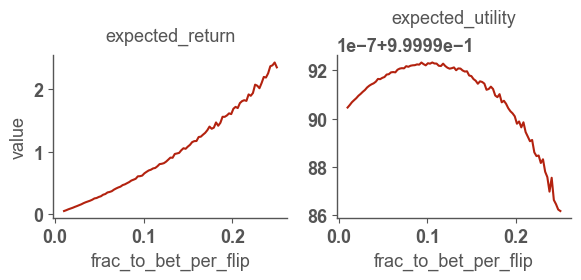

In [11]:
g = sb.FacetGrid(all_results, col="variable", sharey=False)
g.map(sb.lineplot, "frac_to_bet_per_flip", "value")
g.set_titles("{col_name}");

You can see that your expected returns keep going up and up as you bet more of your wealth with each coin flip, whereas your expected utility clearly has a maximum around 10% (with $\gamma=2$).

So if you just want to maximize returns ($\gamma=0$), you should bet 100\% of your wealth on each coin flip. If you want to maximize utility, you should only bet around 10% of your wealth on each coin flip.

In [12]:
all_results.filter(pl.col("variable")=="expected_utility").sort("value", descending=True).head()

frac_to_bet_per_flip,variable,value
f32,str,f64
0.10551,"""expected_utility""",0.999999
0.093265,"""expected_utility""",0.999999
0.100612,"""expected_utility""",0.999999
0.107959,"""expected_utility""",0.999999
0.110408,"""expected_utility""",0.999999


## Analytics

If we play one round of this game, if we bet a fraction $f$ of our wealth, and get heads, our final wealth is $W - fW + sfW = W(1+f)$. Conversely, if we get tails, our final wealth is $W(1-f)$.

After playing the game after $n$ rounds, the number of heads we get, $X$, is a binomially distributed random variable. If our initial wealth is $W_i$ then our final wealth $W_f$ after playing this game is

$$W_f = W_i (1+f)^X(1-f)^{n-X}$$

A binomial random variable is distributed as

$$P(X=x) = \binom{n}{k} p^k (1-p)^{n-k}$$

We also have the definition of returns $R$ as

$$R = \frac{W_f}{W_i} - 1$$

With the consequence that

$$\mathbb{E}(R) = \frac{\mathbb{E}(W_f)}{W_i} - 1$$

So, we can write our expected final wealth after playing the game as

$$\mathbb{E}(W_f) = W_i \sum_x \binom{n}{k} p^k (1-p)^{n-k} (1+f)^x (1-f)^{n-x}$$

and our expected utility as

$$\mathbb{E}(U(W_f)) = \sum_x \binom{n}{k} p^k (1-p)^{n-k} \left( \frac{1-[W_i(1+f)^x(1-f)^{n-x}]^{1-\gamma}}{\gamma-1} \right)$$

In [13]:
from scipy.stats import binom

In [14]:
n_flips = 25
bias = 0.6
n_heads = np.arange(n_flips + 1)
n_heads

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25])

Text(0, 0.5, 'Probability')

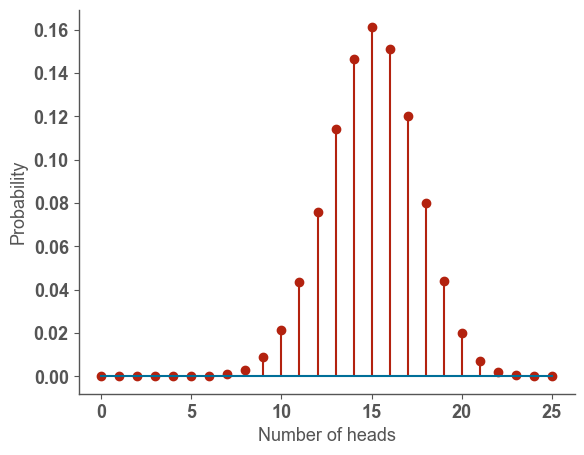

In [15]:
fig, ax = plt.subplots()
ax.stem(n_heads, binom.pmf(n_heads, n_flips, bias)) 
ax.set_xlabel("Number of heads")
ax.set_ylabel("Probability")

In [16]:
all_results_analytic = []
for f in frac_to_bet_per_flip:
    final_wealth = initial_wealth * (1 + f) ** n_heads * (1 - f) ** (n_flips - n_heads)
    expected_return = np.sum(binom.pmf(n_heads, n_flips, bias) * final_wealth)/initial_wealth - 1
    expected_utility = np.sum(
        binom.pmf(n_heads, n_flips, bias) * crra_utility(final_wealth, gamma=2)
    )
    result_analytic = pl.DataFrame(
        {
            "expected_return": expected_return,
            "expected_utility": expected_utility,
        }
    ).with_columns(pl.lit(f, dtype=pl.Float32()).alias("frac_to_bet_per_flip"))
    all_results_analytic.append(result_analytic)
all_results_analytic = pl.concat(all_results_analytic).unpivot(
    index="frac_to_bet_per_flip"
)

In [17]:
all_results_sim_ana = pl.concat(
    [
        all_results.with_columns(pl.lit("simulation").alias("source")),
        all_results_analytic.with_columns(pl.lit("analytic").alias("source")),
    ]
)

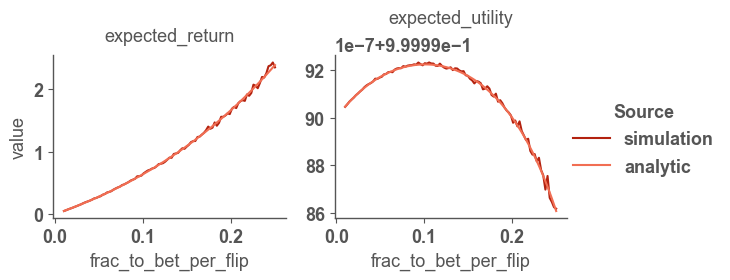

In [18]:
g = sb.FacetGrid(all_results_sim_ana, col="variable", sharey=False)
g.map_dataframe(sb.lineplot, "frac_to_bet_per_flip", "value", hue="source")
g.add_legend(title="Source")
g.set_titles("{col_name}");

## Certainty-equivalent return

Certainty-equivalent return is the return of a risk-free investment that generates utility equal to the expected utility of a risky investment. I.e. if we have a starting wealth of $W_i$, then

$$U(W^*) = \frac{1-(W^*)^{1-\gamma}}{\gamma-1} = \mathbb{E}_W[U(w)] = \sum_w p_w \left(\frac{1-w^{1-\gamma}}{\gamma-1}\right)$$
$$\implies W^* = \left[ 1-(\gamma-1) \mathbb{E}_W[U(w)] \right]^{1/(1-\gamma)}$$
$$CER = \frac{W^*}{W_i} - 1$$

or in other words

$$CER = \frac{\left[ 1-(\gamma-1) \mathbb{E}_W[U(w)] \right]^{1/(1-\gamma)}}{W_i} - 1$$

In [19]:
def certainty_equivalent_return(
    *, initial_wealth: float, expected_utility: float, gamma: float
):
    certainty_equivalent_final_wealth = (1 - (gamma - 1) * expected_utility) ** (
        1 / (1 - gamma)
    )
    certainty_equivalent_return = certainty_equivalent_final_wealth / initial_wealth - 1
    return certainty_equivalent_return


In [28]:
all_results_analytic_cer = all_results_analytic.pivot(on="variable", index="frac_to_bet_per_flip").with_columns(
    pl.col("expected_utility")
    .map_elements(
        lambda u: certainty_equivalent_return(
            initial_wealth=initial_wealth, expected_utility=u, gamma=2.0
        ),
        return_dtype=pl.Float32()
    )
    .alias("certainty_equivalent_return")
).unpivot(index="frac_to_bet_per_flip")

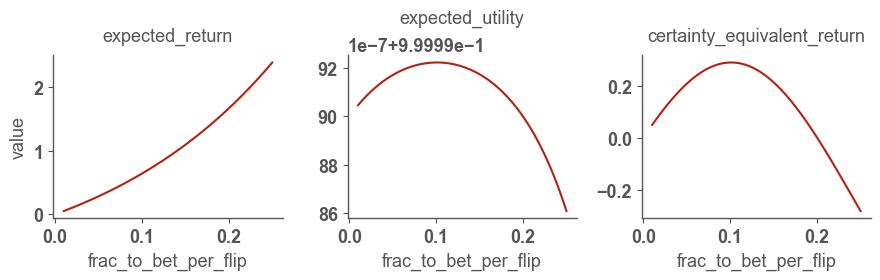

In [30]:
g = sb.FacetGrid(all_results_analytic_cer, col="variable", sharey=False)
g.map_dataframe(sb.lineplot, "frac_to_bet_per_flip", "value")
g.set_titles("{col_name}");

In [37]:
all_results_analytic_cer.pivot(on="variable", index="frac_to_bet_per_flip").sort("certainty_equivalent_return", descending=True).head()

frac_to_bet_per_flip,expected_return,expected_utility,certainty_equivalent_return
f32,f64,f64,f64
0.100612,0.645537,0.999999,0.288954
0.103061,0.665403,0.999999,0.288824
0.098163,0.625898,0.999999,0.288694
0.10551,0.685499,0.999999,0.288303
0.095714,0.606485,0.999999,0.288045


I.e. a financial instrument which generated a riskless return of 29% would yield us indifferent to playing the game outlined here when we play optimally, betting around 10% of our wealth on every round. If we were to play this game optimally, given our level of risk aversion, our average return is 65%.